In [1]:
import numpy as np
from matplotlib import pyplot as plt

from module_.dataLoader import dataLoader
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection

In [2]:
episodes, transitions, labels = dataLoader("testbed")

sensors = set()
for e in episodes:
    sensors = sensors | set(e[:,0])
sensors = sorted(sensors)

tasks: ['Chatting', 'Discussion', 'GroupStudy', 'Presentation']


/home/kisoo/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kisoo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


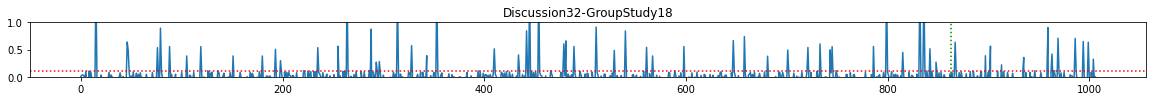

In [7]:
i = 4
episode, transition, label = episodes[i], transitions[i], labels[i]

segmentation_features = np.array(feature_extraction(episode, "testbed", sensors))

score_s = np.array(change_point_detection(segmentation_features, "RuLSIF"))

fig = plt.figure(figsize=(20, 1))
ax = fig.add_subplot(1, 1, 1)

plt.title(label)
plt.ylim(0, 1)
plt.plot(range(len(score_s)), score_s)
plt.axvline(x=transition, color="g", linestyle=":")
plt.axhline(y=0.1, color="r", linestyle=":")

# test on group activity dataset
# statistics of false alarms per activity: (hh101, adlmr, testbed)
# is it problem or not?

In [ ]:
label_list = set()
for label in labels:
    left, right = label.split("-")
    label_list.add(left[0]); label_list.add(right[0])
label_list = sorted(label_list)
print(label_list)
events_dict = {label:(0, 0) for label in label_list}
sensor_dict = {label:(0, 0) for label in label_list}
duration_dict = {label:(0, 0) for label in label_list}
alarm_dict = {label:(0, 0) for label in label_list}

# scores = []
# scores_r = []
for ei in range(len(episodes)):
    if ei%100==0:
        print(ei, len(episodes))
    test_index = ei
    episode, transition, label = episodes[test_index], transitions[test_index], labels[test_index]

    # left
    leftlabel = label.split("-")[0][0]
    events_dict[leftlabel]=(events_dict[leftlabel][0]+len(episode[:transition]),events_dict[leftlabel][1]+1)
    sensor_dict[leftlabel]=(sensor_dict[leftlabel][0]+len(set(episode[:transition,0])),sensor_dict[leftlabel][1]+1)
    duration_dict[leftlabel]=(duration_dict[leftlabel][0]+float(episode[transition-1,2])-float(episode[0,2]),duration_dict[leftlabel][1]+1)

    sensor_list = sorted(set(episode[:,0]))
    segmentation_features = np.array(feature_extraction(episode, "testbed", sensor_list))

    scores = np.array(change_point_detection(segmentation_features[:transition+2], "RuLSIF"))

    alarm_dict[leftlabel]=(alarm_dict[leftlabel][0]+sum([1 for i in range(len(scores[:transition])) if scores[i]>0.1]),alarm_dict[leftlabel][1]+1)

# np.save("./replication/hh101/scores_s.npy", scores_s)
# np.save("./replication/hh101/scores_r.npy", scores_r)



In [ ]:
for k, v in alarm_dict.items():
    print(k, v[0]/v[1])
# for label in labels:
#     print(label)

In [ ]:
score_list = []
for ei in range(len(episodes)):
    if ei%100==0:
        print(ei, len(episodes))
    test_index = ei
    episode, transition, label = episodes[test_index], transitions[test_index], labels[test_index]

    sensor_list = sorted(set(episode[:,0]))
    segmentation_features = np.array(feature_extraction(episode, "testbed", sensor_list))

    scores = np.array(change_point_detection(segmentation_features, "RuLSIF"))
    score_list.append(scores)

np.save("./replication/testbed/scores_r.npy", score_list)

In [ ]:
true_positive = true_negative = false_positive = false_negative = 0

threshold = 0.1

for ei in range(len(episodes)):
    test_index = ei
    episode, transition, label = episodes[test_index], transitions[test_index], labels[test_index]
    scores = score_list[test_index]

    gt_timestamp_l = float(episode[transition-1][2])
    gt_timestamp_r = float(episode[transition][2])

    tp = tn = fp = fn =0
    activation = False
    activation_timestamp = 0
    for j in range(len(episode)):
        s = scores[j]

        score = s
        timestamp = float(episode[j][2])

        if score>=threshold: #POSITIVE
            # if activation and timestamp - activation_timestamp <=20 : #SKIP
            #     if j!=transition:
            #         tn+=1
            #     else:
            #         fn+=1
            #     activation = False
            #     continue
            if j==transition:
                tp+=1
            else:
                if abs(gt_timestamp_l-timestamp)<=5 or abs(gt_timestamp_r-timestamp)<=5:
                    tp+=1
                else:
                    fp+=1
            activation = True
            activation_timestamp = timestamp
        else:
            if j!=transition:
                tn+=1
            else:
                fn+=1

    true_positive+=tp
    true_negative+=tn
    false_positive+=fp
    false_negative+=fn

In [ ]:
true_positive / (true_positive+false_negative), false_positive / (false_positive+true_negative)